<a href="https://colab.research.google.com/github/liebesbachlein/ml_t1d/blob/main/ML_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import sklearn.model_selection as skm
import datetime
from dataclasses import dataclass
import seaborn as sns

from scipy.signal import savgol_filter
import os
import tempfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (accuracy_score,
                             log_loss,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             RocCurveDisplay,
                             f1_score,
                             recall_score,
                             make_scorer,
                             r2_score,
                             mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             make_scorer)


# Data set #1

[Link to the data set: "A Randomized Trial to Assess the Effectiveness of the GlucoWatch Biographer in the Management of Type 1 Diabetes in Children"](https://public.jaeb.org/direcnet/stdy/159)

[Link to the .csv files](https://drive.google.com/drive/folders/19_uTWA-niAYixEpyQuVJVEQI7uEUKHnU?usp=sharing)

In [ ]:
NH_CUTOFF_BG = 3.0
NH_CUTOFF_START = 1
NH_CUTOFF_END = 4

HOUR_AVERAGE = True
MIN_VALID_HOUR = 23

##Data processing / feature engineering

In [ ]:
df = pd.read_csv('dataCGM.csv', sep=',')
df = df.drop('RecID', axis=1)
df["ReadingDt"] = pd.to_datetime(df["ReadingDt"], dayfirst=True)
df["ReadingTm"] = pd.to_timedelta(df["ReadingTm"])
df = df.sort_values(by=['PtID', 'ReadingDt', 'ReadingTm'])

df_a1c = pd.read_csv('dataA1c.csv', sep=',')
df_a1c["SampleDt"] = pd.to_datetime(df_a1c["SampleDt"], dayfirst=True)
df_a1c = df_a1c.sort_values(by=['PtID', 'SampleDt'])

@dataclass
class Entry:
  features_df: pd.core.frame.DataFrame
  target_df: pd.core.frame.DataFrame
  pt: int
  dt: np.datetime64
  a1c: float

  def __str__(self):
    return f"PtID:{self.pt}, A1c:{self.a1c}\n Features DF\n{self.features_df}\nTarget DF\n{self.target_df}\n"


def findA1c(data, pt, dt):
  df = data[pt]
  sampledts = dict()
  for x, y in df.groupby("SampleDt"):
    sampledts.update({x: y})

  diff = datetime.timedelta(days=1000)
  putdt = 0
  for sampledt in sampledts.keys():
    if abs(sampledt - dt) <= diff:
      diff = abs(sampledt - dt)
      putdt = sampledt
  return sampledts[putdt]['A1c'].iloc[0]

  groups_pt = [] # [ Pt=1[ ( (Date), (DataFrame) ) , ... ], Pt=2[ ( (Date), (DataFrame) ) , ... ], ...
for x, y in df.groupby('PtID'):
  group_pt = []
  for data_pt in y.groupby('ReadingDt'):
    group_pt.append(data_pt)
  groups_pt.append(group_pt)

groups_pt_a1c = dict()

for x, y in df_a1c.groupby('PtID'): #(PtID, [DataFrame]), ...
  groups_pt_a1c.update({x: y})

data = [] #            [[Features_DataFrame0, Target_DataFrame0], ...]
          # groups_dt  [( (Date), (DataFrame) ) , ...] per patient's all data
          # group      [(Data), DataFrame]

for groups_dt in groups_pt:
  prev_date = -1
  features_df = -1
  for group in groups_dt:
    if prev_date != -1 and group[0] == prev_date + datetime.timedelta(days=1):
      target_df = group[1]
      a1c = findA1c(groups_pt_a1c, features_df['PtID'].iloc[0], group[0])
      entry = Entry(features_df, target_df, features_df['PtID'].iloc[0], target_df['ReadingDt'].iloc[0], a1c)
      data.append(entry)
      prev_date = group[0]
      features_df = target_df
    else:
      prev_date = group[0]
      features_df = group[1]

def createData(data, features, column_names):
  if len(column_names) != len(features) + 4:
    print("Features don't match column names")
    return -1
  a = []                                # PtID, A1c, TargetDt, Feature0, Feature1, ..., Target
  for i in range(len(column_names)):
    a.append([])
  for entry in data:
    if isMinValidEntry(entry):
      F = []
      check = 0
      for feature in features:
        f = isFeature(entry, hours=feature)
        if f == False:
          check = 1
          break
        F.append(f)
      if check == 1:
        continue
      a[0].append(entry.pt)
      a[1].append(entry.a1c)
      a[2].append(entry.dt)
      for i in range(len(features)):
        a[i + 3].append(F[i])
      a[len(a) - 1].append(isNH(entry))
  A = pd.DataFrame(np.array(a).T, columns=column_names)
  A['PtID'] = A['PtID'].astype(int)
  A['Target'] = A['Target'].astype(int)

  return A

def isFeature(entry, hours):
  features_tm_bg = entry.features_df.values[:, 2:4]
  sum, i = 0, 0
  intt_BG = -1
  for x, y in features_tm_bg:
    if x.seconds//3600 == hours:
      intt_BG = y
      sum = sum + y
      i = i + 1
  if i == 0:
    return False
  if HOUR_AVERAGE == True:
    return round(sum / i, 1)
  else:
    return intt_BG

def isNH(entry):
  target_tm_bg = entry.target_df.values[:, 2:4]
  valid, response = -1, 0
  for x, y in target_tm_bg:
    if x.seconds//3600 >= NH_CUTOFF_START and x.seconds//3600 < NH_CUTOFF_END:
      valid = 1
      if y <= NH_CUTOFF_BG:
        response = 1
  if valid == -1:
    return -1
  return response


def isMinValidEntry (entry):
  if isFeature(entry, MIN_VALID_HOUR) == False or isNH(entry) == -1:
    return False
  return True

# Data set #2

[Link to the data set: "A Randomized Trial Comparing Continuous Glucose Monitoring With and Without Routine Blood Glucose Monitoring in Adults with Type 1 Diabetes"](https://public.jaeb.org/datasets/diabetes)

[Link to the .csv files](https://drive.google.com/drive/folders/1LCKiHVT_htbGY3YBbeSTp7fSlyW-t4y1?usp=sharing)

## Approach #1 (Binary Classification)

In [ ]:
NH_CUTOFF_BG = 4.0
NH_CUTOFF_START = 1
NH_CUTOFF_END = 4

MIN_VALID_HOUR = (23, 0)

###Data processing / feature engineering

In [ ]:
######################################################### target

df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Initial/HDeviceCGM.txt', sep='|')

df['GlucoseValue'] = round(df['GlucoseValue'] * 0.0555, 1)
df = df.drop(columns = ['RecID', 'ParentHDeviceUploadsID', 'SiteID', 'DexInternalDtTmDaysFromEnroll','DexInternalTm', 'RecordType'])
df['PtID'] = df['PtID'].astype(int)
df['DeviceDtTmDaysFromEnroll'].astype(int)
df = df.sort_values(by=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm'])
df.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/CGM_data_device.csv', index=False)

df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/CGM_data_device.csv')

df['DeviceTm'] = pd.to_timedelta(df['DeviceTm'])

@dataclass
class Entry:
  features_df: pd.core.frame.DataFrame
  target_df: pd.core.frame.DataFrame
  pt: int
  dt: int

  def __str__(self):
      return f"PtID:{self.pt}\n Features DF\n{self.features_df}\nTarget DF\n{self.target_df}\n"

def createData(data, features, column_names): #features = [(22, 30), {23, 30}]
  if len(column_names) != len(features) + 3:
    print("Features don't match column names")
    return -1
  a = []                                # PtID, TargetDt, Feature0, Feature1, ..., Target
  for i in range(len(column_names)):
    a.append([])
  for entry in data:
    if isMinValidEntry(entry):
      F = []
      check = 0
      for feature in features:
        f = isFeature(entry, feature)
        if f == -1:
          check = 1
          break
        F.append(f)
      if check == 1:
        continue
      a[0].append(entry.pt)
      a[1].append(entry.dt)
      for i in range(len(features)):
        a[i + 2].append(F[i])
      a[len(a) - 1].append(isNH(entry))
  A = pd.DataFrame(np.array(a).T, columns=column_names)
  A['PtID'] = A['PtID'].astype(int)
  A['Target'] = A['Target'].astype(int)

  return A

def isFeature(entry, time):
  features_tm_bg = entry.features_df.values[:, 2:4]
  for x, y in features_tm_bg:
    hours = x.seconds//3600
    minutes = (x.seconds - hours*3600) // 60
    if hours == time[0]:
      if abs(time[1] - minutes) <= 5:
        return y
  return -1

def isNH(entry):
  target_tm_bg = entry.target_df.values[:, 2:4]
  valid, response = -1, 0
  for x, y in target_tm_bg:
    if x.seconds//3600 >= NH_CUTOFF_START and x.seconds//3600 < NH_CUTOFF_END:
      valid = 1
      if y <= NH_CUTOFF_BG:
        response = 1
  if valid == -1:
    return -1
  return response


def isMinValidEntry (entry):
  if isFeature(entry, MIN_VALID_HOUR) == -1 or isNH(entry) == -1:
    return False
  return True

print('0')
groups_pt = [] # [ Pt=1[ ( (Date), (DataFrame) ) , ... ], Pt=2[ ( (Date), (DataFrame) ) , ... ], ...
for x, y in df.groupby('PtID'):
  group_pt = []
  for data_pt in y.groupby('DeviceDtTmDaysFromEnroll'):
    group_pt.append(data_pt)
  groups_pt.append(group_pt)

data = [] #            [[Features_DataFrame0, Target_DataFrame0], ...]
          # groups_dt  [( (Date), (DataFrame) ) , ...] per patient's all data
          # group      [(Data), DataFrame]
print('1')
for groups_dt in groups_pt:
  prev_date = -1
  features_df = -1
  for group in groups_dt:
    if prev_date != -1 and group[0] == prev_date + 1:
      target_df = group[1]
      entry = Entry(features_df, target_df, features_df['PtID'].iloc[0], target_df['DeviceDtTmDaysFromEnroll'].iloc[0])
      data.append(entry)
      prev_date = group[0]
      features_df = target_df
    else:
      prev_date = group[0]
      features_df = group[1]
print('2')

A = createData(data, [[23,40], [23,20], [23,0]], ['PtID','TargetDt','f23:40','f23:20','f23:00','Target'])
A = A.dropna()
A['PtID'] = A['PtID'].astype(int)
A['TargetDt'] = A['TargetDt'].astype(int)
A.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_23=40_20_00.csv', index=False)

0
1
2


In [ ]:
# df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_23=40_20_00.csv')
# (51014, 6), no N/A

In [ ]:
######################################################### A1c
df_a1c = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Initial/HLocalHbA1c.txt', sep='|')
df_a1c = df_a1c.drop(columns=['RecID', 'SiteID', 'Visit', 'HbA1cTestMethod', 'HbA1cNotDone'])
df_a1c = df_a1c.dropna()
df_a1c = df_a1c.sort_values(by=['PtID', 'HbA1cTestDtDaysAfterEnroll'])
df_a1c.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/A1c_data.csv', index=False)

######################################################### bmi
df_profile = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Initial/HScreening.txt', sep='|')
df_profile['Height'] = df_profile['Height'] / 100
bmi = round(df_profile['Weight'] / ( df_profile['Height'] * df_profile['Height'] ), 1)
df_bmi = pd.DataFrame(df_profile['PtID'].values, columns=['PtID'])
df_bmi.insert(df_bmi.shape[1], 'BMI', bmi)
df_bmi = df_bmi.sort_values(by='PtID')
df_bmi = df_bmi.dropna()
df_bmi.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Pt_profile_bmi.csv', index=False)

######################################################### insulin
df_insulin = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Initial/HDeviceBolus.txt', sep='|')
ins = df_insulin.values[:, [2, 4, 5, 9]]
df_ins = pd.DataFrame(ins, columns=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm', 'Insulin'])
df_ins = df_ins.sort_values(by=['PtID', 'DeviceDtTmDaysFromEnroll', 'DeviceTm'])
df_ins = df_ins.dropna()
df_ins.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Insulin_data.csv', index=False)

In [ ]:
from scipy.stats import linregress
######################################################### A1c
def findA1c(data, pt, dt):
  df = data[pt]
  sampledts = dict()
  for dt_id, y in df.groupby("HbA1cTestDtDaysAfterEnroll"):
    sampledts.update({dt_id: y})

  diff = 10000
  putdt = 0
  for sampledt in sampledts.keys():
    if abs(sampledt - dt) <= diff:
      diff = abs(sampledt - dt)
      putdt = sampledt
  return sampledts[putdt]['HbA1cTestRes'].iloc[0]

df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_23=40_20_00.csv')
df_a1c = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/A1c_data.csv')

a1c = df_a1c.values
cols = list(df_gv.columns)
cols.append('A1c')
vals = df_gv.values

groups_pt_a1c = dict()

for x, y in df_a1c.groupby('PtID'):
  groups_pt_a1c.update({x: y})

a1c_arr = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    row = j.values
    a1c = findA1c(groups_pt_a1c, pt_id, int(dt))
    a1c_arr.append(a1c)

if (df_gv.shape[0] != len(a1c_arr)):
  print('Something\'s wrong! Shapes don\'t match!')

df_gv.insert(df_gv.shape[1], 'A1c', a1c_arr)

df_gv = df_gv.dropna()

######################################################### bmi

df_profile = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Pt_profile_bmi.csv')

arr = []
for i in range(df_gv.shape[0]):
  arr.append(False)

#df_gv.insert(df_gv.shape[1], 'DiagAge', arr)
df_gv.insert(df_gv.shape[1], 'BMI', arr)

groups_profile = dict()

for x, y in df_profile.groupby('PtID'):
  #groups_profile.update({x: [y['DiagAge'].iloc[0], y['BMI'].iloc[0]]})
  groups_profile.update({x: y['BMI'].iloc[0]})

arr_vals = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    if pt_id in groups_profile.keys():
      #j['DiagAge'] = groups_profile[pt_id][0]
      #j['BMI'] = groups_profile[pt_id][1]
      #arr_vals.append(j.values[0])
      j['BMI'] = groups_profile[pt_id]
      arr_vals.append(j.values[0])

df_gv = pd.DataFrame(arr_vals, columns = df_gv.columns)
df_gv= df_gv.dropna()

######################################################### t1d

""" df_profile = pd.read_csv('T1D_Condition_pros.csv')

arr = []
for i in range(df_gv.shape[0]):
  arr.append(False)

df_gv.insert(df_gv.shape[1], 'Duration', arr)
df_gv.insert(df_gv.shape[1], 'MedCondStatus', arr)

groups_profile = dict()

for x, y in df_profile.groupby('PtID'):
  groups_profile.update({x: [y['Duration'].iloc[0], y['MedCondStatus'].iloc[0]]})


arr_vals = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    if pt_id in groups_profile.keys():
      j['Duration'] = groups_profile[pt_id][0]
      j['MedCondStatus'] = groups_profile[pt_id][1]
      arr_vals.append(j.values[0])

df_gv = pd.DataFrame(arr_vals, columns = df_gv.columns)
df_gv = df_gv.dropna() """

######################################################### insulin
'''
df_profile = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Insulin_data.csv')

arr = []
for i in range(df_gv.shape[0]):
  arr.append(False)

df_profile ['DeviceTm'] =  pd.to_timedelta(df_profile ["DeviceTm"])

df_gv.insert(df_gv.shape[1], 'IOB', arr)
df_gv.insert(df_gv.shape[1], 'LastIns', arr)

groups_profile = dict()

for x, y in df_profile.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    last = l.drop(columns = ['PtID', 'DeviceDtTmDaysFromEnroll']).values
    sm = 0
    for i in l['Insulin'].values:
      sm = sm + i
    last = pd.to_timedelta(list(l['DeviceTm'].values).pop()).seconds//3600
    groups_profile.update({(x, k): (sm, last)})


arr_vals = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    if (pt_id, dt - 1) in groups_profile.keys():
      j['IOB'] = groups_profile[(pt_id, dt - 1)][0]
      j['LastIns'] = groups_profile[(pt_id, dt - 1)][1]
      arr_vals.append(j.values[0])

df_gv = pd.DataFrame(arr_vals, columns = df_gv.columns)
df_gv = df_gv.dropna()
'''
########################################### slope

arr = []
for i in range(df_gv.shape[0]):
  arr.append(False)

df_gv.insert(df_gv.shape[1], 'Slope', arr)

arr_vals = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    slope = linregress([0, 1, 2], [j['f23:00'].iloc[0], j['f23:20'].iloc[0], j['f23:40'].iloc[0]]).slope
    j['Slope'] = round(slope, 2)
    arr_vals.append(j.values[0])

df_gv = pd.DataFrame(arr_vals, columns = df_gv.columns)
df_gv = df_gv.dropna()

############################### hypo

""" df_gv = pd.read_csv('test_slope.csv')
df_26 = pd.read_csv('Hypo_fear_26weeks.csv')
df_scr = pd.read_csv('Hypo_fear_screening.csv')

arr = []
for i in range(df_gv.shape[0]):
  arr.append(False)

cols = ['LgSnackBed','TestBGRunHigh','HighBGAlone','EatFirstSignLowBG','KeepHighBGMtg','CarryFastActSug']

hypo_scr = dict()
hypo_26 = dict()

for pt, y in df_scr.groupby('PtID'):
  hypo_scr.update({pt: y.values[0][1:df_scr.shape[1]]})

for pt, y in df_26.groupby('PtID'):
  hypo_26.update({pt: y.values[0][1:df_26.shape[1]]})

arr_vals = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    if dt > 60:
      if pt_id in hypo_26.keys():
        a = list(j.values[0])
        for s in hypo_26[pt_id]:
          a.append(s)
        arr_vals.append(a)
    else:
      if pt_id in hypo_scr.keys():
        a = list(j.values[0])
        for s in hypo_scr[pt_id]:
          a.append(s)
        arr_vals.append(a)

new_cols = list(df_gv.columns)
for i in cols:
  new_cols.append(i)

df_gv = pd.DataFrame(arr_vals, columns = new_cols)
df_gv = df_gv.dropna() """

############################### refining

cols = ['PtID', 'Target', 'TargetDt']

for i in cols:
    df_gv[i] = df_gv[i].astype(int)

df_gv.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3target_a1c_bmi_slope.csv', index=False)

In [ ]:
# df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3target_a1c_bmi_slope.csv')
# (51014, 9), no N/A

In [ ]:
############################### pruning
df_ins = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Insulin_data.csv')
df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3target_a1c_bmi_slope.csv')

ex_gv = set()
ex_ins = set()

df_ins['DeviceTm'] =  pd.to_timedelta(df_ins["DeviceTm"])

for x, y in df_ins.groupby('PtID'):
  for k, l in df_ins.groupby('DeviceDtTmDaysFromEnroll'):
    tm = l['DeviceTm'].values
    first = pd.to_timedelta(list(l['DeviceTm'].values)[0]).seconds//3600
    if first < 6 :
        ex_gv.add((x, k))
        ex_ins.add((x, k))

for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    tm = l['DeviceTm'].values
    last = pd.to_timedelta(list(l['DeviceTm'].values).pop()).seconds//3600
    if last >= 23 :
        ex_gv.add((x, k + 1))
        ex_ins.add((x, k))

arr_gv = []
for x, y in df_gv.groupby('PtID'):
  for k, l in y.groupby('TargetDt'):
    s = (x, k)
    if s not in ex_gv:
      arr_gv.append(l.values[0])

df_GV_untuned = pd.DataFrame(arr_gv, columns=df_gv.columns)
df_GV_untuned = df_GV_untuned.dropna()
#df_GV_untuned.to_csv('gv_pruned_untuned.csv', index=False)

arr_ins = []
for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    for p, h in l.groupby('DeviceTm'):
      s = (x, k)
      if s not in ex_ins:
        arr_ins.append(h.values[0])


df_INS_untuned = pd.DataFrame(arr_ins, columns=df_ins.columns)
df_INS_untuned = df_INS_untuned.dropna()
#df_INS_untuned.to_csv('ins_pruned_untuned.csv', index=False)

############################### tuning
df_ins = df_INS_untuned
df_gv = df_GV_untuned

#clean INS
l = []
for pt, x in df_gv.groupby('PtID'):
    for dt, y in x.groupby('TargetDt'):
        l.append((pt, dt - 1))

arr = []
for pt, x in df_ins.groupby('PtID'):
    for dt, y in x.groupby('DeviceDtTmDaysFromEnroll'):
      for p, h in y.groupby('DeviceTm'):
        if (pt, dt) in l:
            arr.append(h.values[0])

df_ins_new = pd.DataFrame(arr, columns=df_ins.columns)
df_ins_new.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3t_3_ins_Tuned.csv', index=False)

#clean GV
l = []
for pt, x in df_ins_new.groupby('PtID'):
    for dt, y in x.groupby('DeviceDtTmDaysFromEnroll'):
        l.append((pt, dt + 1))

arr = []
for pt, x in df_gv.groupby('PtID'):
    for dt, y in x.groupby('TargetDt'):
        if (pt, dt) in l:
            arr.append(y.values[0])

df_gv_new = pd.DataFrame(arr, columns=df_gv.columns)
df_gv_new.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3target_a1c_bmi_slope_Tuned.csv', index=False)

In [ ]:
############################### insulin
df_ins = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3t_3_ins_Tuned.csv')
df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3target_a1c_bmi_slope_Tuned.csv')
df_ins['DeviceTm'] =  pd.to_timedelta(df_ins["DeviceTm"])

d = dict()
for pt, x in df_gv.groupby('PtID'):
  for dt, y in x.groupby('TargetDt'):
    d[(pt, dt-1)] = 0

for pt, x in df_ins.groupby('PtID'):
  for dt, y in x.groupby('DeviceDtTmDaysFromEnroll'):
    for tm, z in y.groupby('DeviceTm'):
      if tm.seconds//3600 >= 21:
        d[(pt, dt)] = d[(pt, dt)] + z['Insulin'].iloc[0]

arr = []
for i in d.keys():
  arr.append(d[i])

df_gv.insert(df_gv.shape[1], 'IOB21', arr)
df_gv.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/3target_a1c_bmi_slope_iob.csv', index=False)

## Aproach #2 (Imbalanced, ANN)

[Reference](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [ ]:
df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned_Smooth.csv')
X = df.values[:, 2:62]
y = df['Target'].astype(int)

In [ ]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 36073
    Positive: 3786 (10.50% of total)



In [ ]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc = np.clip(X_train_sc, -5, 5)
X_train_sc = np.clip(X_train_sc, -5, 5)

In [ ]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

##### De16, Dr0.5, De1

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train_sc.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  return model

EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                976       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 993 (3.88 KB)
Trainable params: 993 (3.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.predict(X_train_sc[:10])

1/1 [==============================] - 4s 4s/step


array([[0.66773736],
       [0.6135322 ],
       [0.5656299 ],
       [0.5455424 ],
       [0.32540873],
       [0.64598006],
       [0.67405   ],
       [0.57189643],
       [0.7136719 ],
       [0.5738588 ]], dtype=float32)

In [ ]:
results = model.evaluate(X_train_sc, y_train, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.9087


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.14335462])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(X_train_sc[:10])

1/1 [==============================] - 0s 71ms/step


array([[0.1521851 ],
       [0.06969231],
       [0.0827447 ],
       [0.9483754 ],
       [0.26284546],
       [0.16685818],
       [0.31702027],
       [0.06972578],
       [0.11348793],
       [0.0614496 ]], dtype=float32)

In [ ]:
results = model.evaluate(X_train_sc, y_train, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5094


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train_sc,
    y_train,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_sc, y_test))

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  plt.figure(figsize=(10, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='g', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()
  plt.show ()



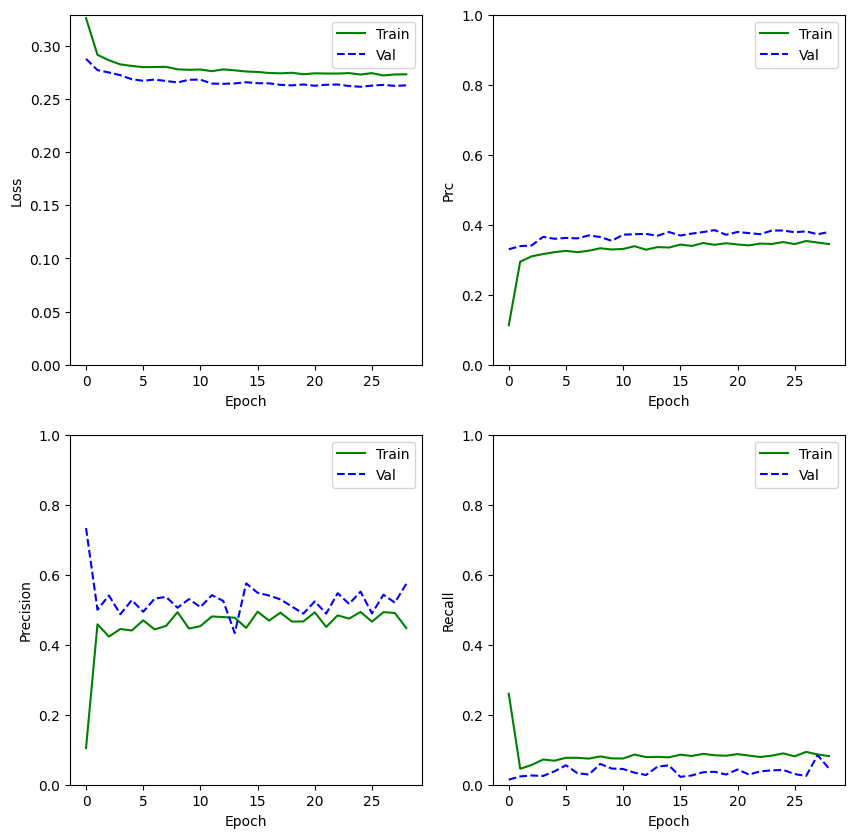

In [ ]:
plot_metrics(baseline_history)

##### De32, Dr0.5, De1

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          32, activation='relu',
          input_shape=(X_train_sc.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  return model

EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train_sc,
    y_train,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_sc, y_test))

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  plt.figure(figsize=(10, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='g', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()
  plt.show ()



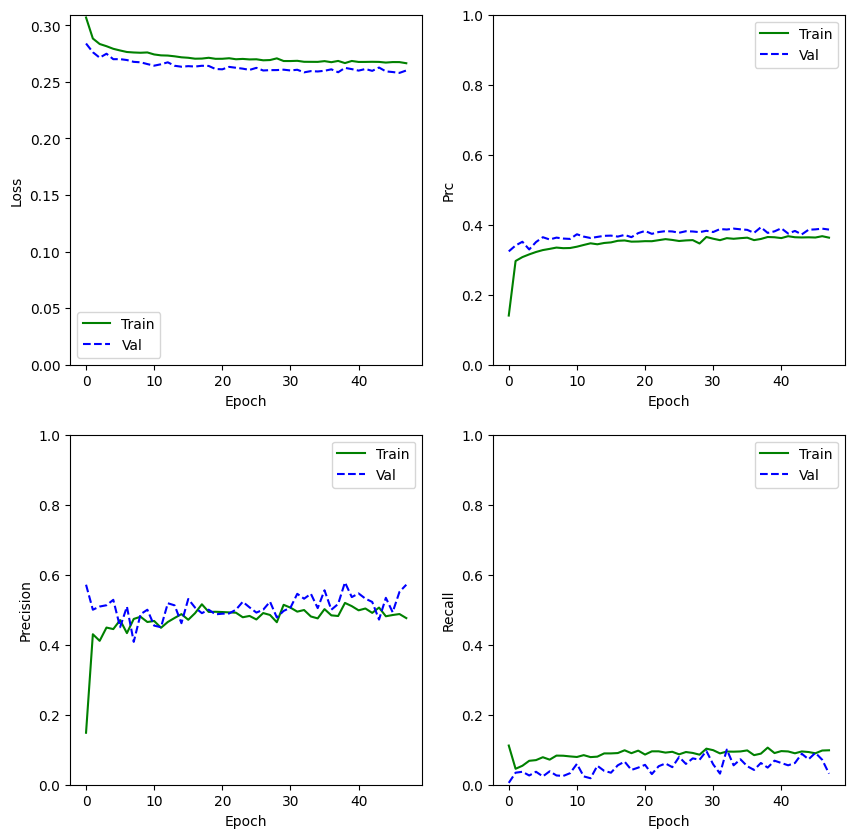

In [ ]:
plot_metrics(baseline_history)

##### De64, De64, De10, De1

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          32, activation='relu',
          input_shape=(X_train_sc.shape[-1],)),
      keras.layers.Dense(
          32, activation='relu',
          input_shape=(64,)),
      keras.layers.Dense(
          10, activation='relu',
          input_shape=(64,)),
      #keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  return model

EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
#model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train_sc,
    y_train,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_sc, y_test))

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  plt.figure(figsize=(10, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='g', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()
  plt.show ()



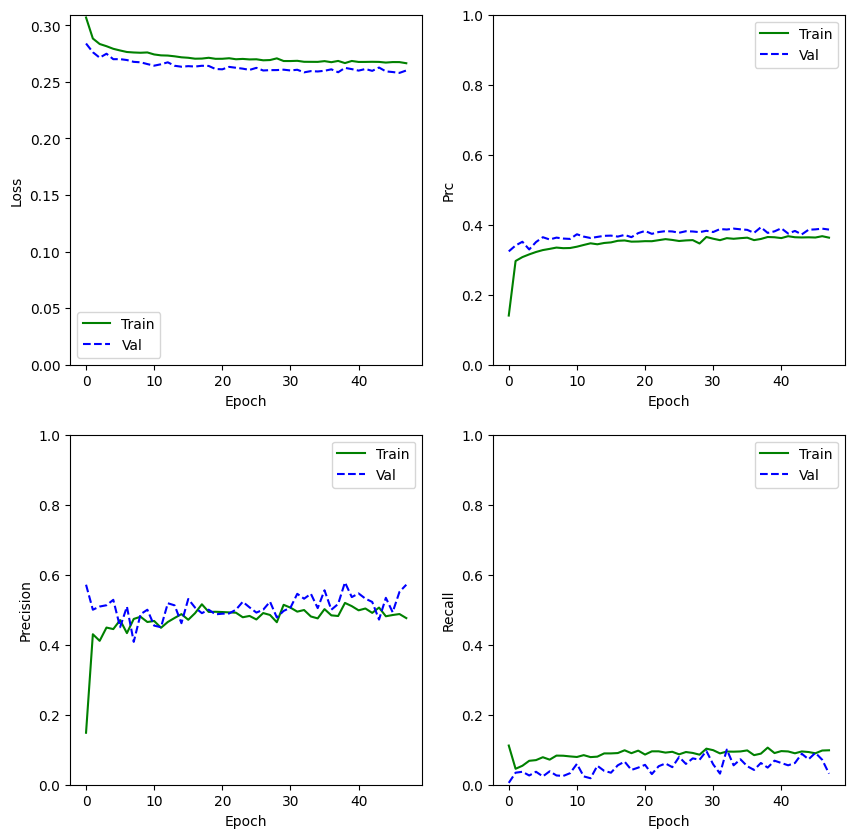

In [ ]:
plot_metrics(baseline_history)

##### CNN

In [ ]:
X_train_sc = X_train_sc[:, :, np.newaxis]

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(filters=10, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=10, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
'''
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= METRICS)
baseline_history = model.fit(
    X_train_sc,
    y_train,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_sc, y_test))
'''

## Aproach #3 (Regression)

In [ ]:
NH_CUTOFF_BG = 4.0
NH_CUTOFF_START = 1
NH_CUTOFF_END = 3
MIN_VALID_HOUR = (23, 0)

###Data processing / feature engineering

In [ ]:
############################### features

df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/CGM_data_device.csv')

df["DeviceTm"] = pd.to_timedelta(df["DeviceTm"])

@dataclass
class Entry:
  features_df: pd.core.frame.DataFrame
  target_df: pd.core.frame.DataFrame
  pt: int
  dt: int

  def __str__(self):
      return f"PtID:{self.pt}\n Features DF\n{self.features_df}\nTarget DF\n{self.target_df}\n"

def createData(data, features, column_names): #features = [(22, 30), {23, 30}]
  if len(column_names) != len(features) + 3:
    print("Features don't match column names")
    return -1
  a = []                                # PtID, TargetDt, Feature0, Feature1, ..., Target
  for i in range(len(column_names)):
    a.append([])
  for entry in data:
    if isMinValidEntry(entry):
      F = []
      check = 0
      for feature in features:
        f = isFeature(entry, feature)
        if f == -1:
          check = 1
          break
        F.append(f)
      if check == 1:
        continue
      a[0].append(entry.pt)
      a[1].append(entry.dt)
      for i in range(len(features)):
        a[i + 2].append(F[i])
      a[len(a) - 1].append(isNH(entry))
  A = pd.DataFrame(np.array(a).T, columns=column_names)
  A['PtID'] = A['PtID'].astype(int)
  A['Target'] = A['Target'].astype(int)

  return A

def isFeature(entry, time):
  features_tm_bg = entry.features_df.values[:, 2:4]
  for x, y in features_tm_bg:
    hours = x.seconds//3600
    minutes = (x.seconds - hours*3600) // 60
    if hours == time[0]:
      if abs(time[1] - minutes) <= 5:
        return y
  return -1

def isNH(entry):
  target_tm_bg = entry.target_df.values[:, 2:4]
  valid, response = -1, 0
  for x, y in target_tm_bg:
    if x.seconds//3600 >= NH_CUTOFF_START and x.seconds//3600 < NH_CUTOFF_END:
      valid = 1
      if y <= NH_CUTOFF_BG:
        response = 1
  if valid == -1:
    return -1
  return response


def isMinValidEntry (entry):
  if isFeature(entry, MIN_VALID_HOUR) == -1 or isNH(entry) == -1:
    return False
  return True

groups_pt = [] # [ Pt=1[ ( (Date), (DataFrame) ) , ... ], Pt=2[ ( (Date), (DataFrame) ) , ... ], ...
for x, y in df.groupby('PtID'):
  group_pt = []
  for data_pt in y.groupby('DeviceDtTmDaysFromEnroll'):
    group_pt.append(data_pt)
  groups_pt.append(group_pt)

data = [] #            [[Features_DataFrame0, Target_DataFrame0], ...]
          # groups_dt  [( (Date), (DataFrame) ) , ...] per patient's all data
          # group      [(Data), DataFrame]
print('1')
for groups_dt in groups_pt:
  prev_date = -1
  features_df = -1
  for group in groups_dt:
    if prev_date != -1 and group[0] == prev_date + 1:
      target_df = group[1]
      entry = Entry(features_df, target_df, features_df['PtID'].iloc[0], target_df['DeviceDtTmDaysFromEnroll'].iloc[0])
      data.append(entry)
      prev_date = group[0]
      features_df = target_df
    else:
      prev_date = group[0]
      features_df = group[1]

features = []
cols = ['PtID','TargetDt']
hh = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
mm = [0, 10, 20, 30, 40, 50]
for h in hh:
  for m in mm:
    features.append([h, m])
    cols.append('f' + str(h) + ':' + str(m))
cols.append('Target')

print('2')
A = createData(data, features, cols)
A = A.dropna()
A['PtID'] = A['PtID'].astype(int)
A['TargetDt'] = A['TargetDt'].astype(int)
A.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp.csv', index=False)

1
2


In [ ]:
############################### target
def isFeature2(data, time):
  for x, y in data.groupby('DeviceTm'):
    hours = x.seconds//3600
    minutes = (x.seconds - hours*3600) // 60
    if hours == time[0]:
      if abs(time[1] - minutes) <= 5:
        return y['GlucoseValue'].iloc[0]
  return 'na'

#df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/exp_target_Tuned.csv')
df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp.csv')
df_all = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/CGM_data_device.csv')

df_all['DeviceTm'] = pd.to_timedelta(df_all['DeviceTm'])

total = dict()

print('1')

for pt, i in df.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    s = dict()
    s['0030'] = 'na'
    s['0050'] = 'na'
    s['0110'] = 'na'
    total[(pt, dt)] = s
print('2')
for pt, i in df_all.groupby('PtID'):
  for dt, j in i.groupby('DeviceDtTmDaysFromEnroll'):
    if (pt, dt) in total.keys():
      total[(pt, dt)]['0030'] = isFeature2(j, (0, 30))
      total[(pt, dt)]['0050'] = isFeature2(j, (0, 50))
      total[(pt, dt)]['0110'] = isFeature2(j, (1, 10))
print('3')
arr0030 = []
arr0050 = []
arr0110 = []
for i in total.keys():
  arr0030.append(total[i]['0030'])
  arr0050.append(total[i]['0050'])
  arr0110.append(total[i]['0110'])
print('4')
df.insert(df.shape[1], 't00:30', arr0030)
df.insert(df.shape[1], 't00:50', arr0050)
df.insert(df.shape[1], 't01:10', arr0110)

arr = []
for pt, i in df.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    if j['t00:30'].iloc[0] != 'na' and j['t00:50'].iloc[0] != 'na' and j['t01:10'].iloc[0] != 'na':
      arr.append(j.values[0])

dd = pd.DataFrame(arr, columns = df.columns)

dd['t00:30'] = dd['t00:30'].astype(float)
dd['t00:50'] = dd['t00:50'].astype(float)
dd['t01:10'] = dd['t01:10'].astype(float)
dd.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_3regres.csv', index=False)

1
2
3
4


In [ ]:
############################### pruning
df_ins = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Insulin_data.csv')
df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_3regres.csv')

ex_gv = set()
ex_ins = set()

df_ins['DeviceTm'] =  pd.to_timedelta(df_ins["DeviceTm"])

for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    tm = l['DeviceTm'].values
    first = pd.to_timedelta(list(l['DeviceTm'].values)[0]).seconds//3600
    if first < 6 :
      ex_gv.add((x, k))
      ex_ins.add((x, k))

for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    tm = l['DeviceTm'].values
    last = pd.to_timedelta(list(l['DeviceTm'].values).pop()).seconds//3600
    if last >= 23 :
      ex_gv.add((x, k + 1))
      ex_ins.add((x, k))

arr_gv = []
for x, y in df_gv.groupby('PtID'):
  for k, l in y.groupby('TargetDt'):
    s = (x, k)
    if s not in ex_gv:
      arr_gv.append(l.values[0])

df_GV_untuned = pd.DataFrame(arr_gv, columns=df_gv.columns)
df_GV_untuned = df_GV_untuned.dropna()
#df_GV_untuned.to_csv('gv_pruned_untuned.csv', index=False)

arr_ins = []
for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    for p, h in l.groupby('DeviceTm'):
      s = (x, k)
      if s not in ex_ins:
        arr_ins.append(h.values[0])


df_INS_untuned = pd.DataFrame(arr_ins, columns=df_ins.columns)
df_INS_untuned = df_INS_untuned.dropna()
#df_INS_untuned.to_csv('ins_pruned_untuned.csv', index=False)

############################### tuning
df_ins = df_INS_untuned
df_gv = df_GV_untuned

#clean INS
l = []
for pt, x in df_gv.groupby('PtID'):
  for dt, y in x.groupby('TargetDt'):
    l.append((pt, dt - 1))

arr = []
for pt, x in df_ins.groupby('PtID'):
  for dt, y in x.groupby('DeviceDtTmDaysFromEnroll'):
    for p, h in y.groupby('DeviceTm'):
      if (pt, dt) in l:
        arr.append(h.values[0])

df_ins_new = pd.DataFrame(arr, columns=df_ins.columns)
df_ins_new.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/expt_ins_Tuned.csv', index=False)

#clean GV
l = []
for pt, x in df_ins_new.groupby('PtID'):
  for dt, y in x.groupby('DeviceDtTmDaysFromEnroll'):
    l.append((pt, dt + 1))

arr = []
for pt, x in df_gv.groupby('PtID'):
  for dt, y in x.groupby('TargetDt'):
    if (pt, dt) in l:
      arr.append(y.values[0])

df_gv_new = pd.DataFrame(arr, columns=df_gv.columns)
df_gv_new.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/exp_target_Tuned.csv', index=False)

In [ ]:
############################### expand insulin
df_ins = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/expt_ins_Tuned.csv')

df_ins['DeviceTm'] =  pd.to_timedelta(df_ins["DeviceTm"])

hh = dict()
for i in range(14, 24):
  hh[i] = 'f' + str(i) + ':'

mm = dict()
for i in [0, 10, 20, 30, 40, 50]:
  mm[i] = str(i)

cols = []
for i in hh.keys():
  for j in mm.keys():
    cols.append(hh[i] + mm[j])

def isIns(tm, ins, r):
  hours = tm.seconds//3600
  minutes = (tm.seconds - hours*3600) // 600
  minutes = minutes * 10
  if hours not in hh.keys():
    return r
  else:
    ss = hh[hours] + mm[minutes]
    if r[ss] == 0:
      r[ss] = ins
    else:
      r[ss] = ins + r[ss]
    return r

arr = []
pt = []
dt = []

for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    row = dict()
    for i in cols:
      row[i] = 0
    for tm, h in l.groupby('DeviceTm'):
      row = isIns(tm, h['Insulin'].iloc[0], row)
    pt.append(x)
    dt.append(k)
    arr.append(list(row.values()))

dd = pd.DataFrame(arr, columns = cols)
dd.insert(0, 'DeviceDtTmDaysFromEnroll', dt)
dd.insert(0, 'PtID', pt)

dd.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/expt_exp_ins_Tuned.csv', index=False)

In [ ]:
############################### A1c
def findA1c(data, pt, dt):
  df = data[pt]
  sampledts = dict()
  for dt_id, y in df.groupby("HbA1cTestDtDaysAfterEnroll"):
    sampledts.update({dt_id: y})

  diff = 10000
  putdt = 0
  for sampledt in sampledts.keys():
    if abs(sampledt - dt) <= diff:
      diff = abs(sampledt - dt)
      putdt = sampledt
  return sampledts[putdt]['HbA1cTestRes'].iloc[0]

df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/exp_target_Tuned.csv')
df_a1c = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/A1c_data.csv')

a1c = df_a1c.values
cols = list(df_gv.columns)
cols.append('A1c')
vals = df_gv.values

groups_pt_a1c = dict()

for x, y in df_a1c.groupby('PtID'):
  groups_pt_a1c.update({x: y})

a1c_arr = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    row = j.values
    a1c = findA1c(groups_pt_a1c, pt_id, int(dt))
    a1c_arr.append(a1c)

if (df_gv.shape[0] != len(a1c_arr)):
  print('Something\'s wrong! Shapes don\'t match!')

df_gv.insert(df_gv.shape[1], 'A1c', a1c_arr)

df_gv = df_gv.dropna()

############################### bmi

df_profile = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Pt_profile_bmi.csv')

arr = []
for i in range(df_gv.shape[0]):
  arr.append(False)

#df_gv.insert(df_gv.shape[1], 'DiagAge', arr)
df_gv.insert(df_gv.shape[1], 'BMI', arr)

groups_profile = dict()

for x, y in df_profile.groupby('PtID'):
  #groups_profile.update({x: [y['DiagAge'].iloc[0], y['BMI'].iloc[0]]})
  groups_profile.update({x: y['BMI'].iloc[0]})

arr_vals = []
for pt_id, i in df_gv.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    if pt_id in groups_profile.keys():
      #j['DiagAge'] = groups_profile[pt_id][0]
      #j['BMI'] = groups_profile[pt_id][1]
      #arr_vals.append(j.values[0])
      j['BMI'] = groups_profile[pt_id]
      arr_vals.append(j.values[0])

df_gv = pd.DataFrame(arr_vals, columns = df_gv.columns)
df_gv= df_gv.dropna()
target = df_gv['Target']
df_gv = df_gv.drop('Target', axis=1)
df_gv.insert(65, 'Target', target.values)
df_gv.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_3regres_a1c_bmi.csv', index=False)

In [ ]:
df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_3regres_a1c_bmi.csv')
df_ins = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/expt_exp_ins_Tuned.csv')

#print([df_gv.shape, df_ins.shape]) #[(11490, 68), (11490, 62)], no N/A

In [ ]:
for i in range(df_gv['Target'].shape[0]):
  if df_gv['Target'].iloc[i] == 1:
    df_gv['Target'].iloc[i] = 0
  else:
    df_gv['Target'].iloc[i] = 1
df_gv['Target'] = df_gv['Target'].astype(int)

df_gv.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_3regres_a1c_bmi.csv', index=False)

### Plot

In [ ]:
df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_3regres_a1c_bmi.csv')
df_ins = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/expt_exp_ins_Tuned.csv')
df_bg = df_gv.drop(columns=['A1c', 'BMI'])
print([df_bg.shape, df_ins.shape])
df_bg['Target'] = df_bg['Target'] * 5

[(11490, 66), (11490, 62)]


In [ ]:
mm = [':0', ':1', ':2', ':3', ':4', ':5']
hh = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

cols_ins = []
for h in hh:
  for m in  mm:
    cols_ins.append(h + m)

cols_bg = cols_ins.copy()
cols_bg.append('0:3')
cols_bg.append('0:5')
cols_bg.append('1:1')
cols_bg.append('T')

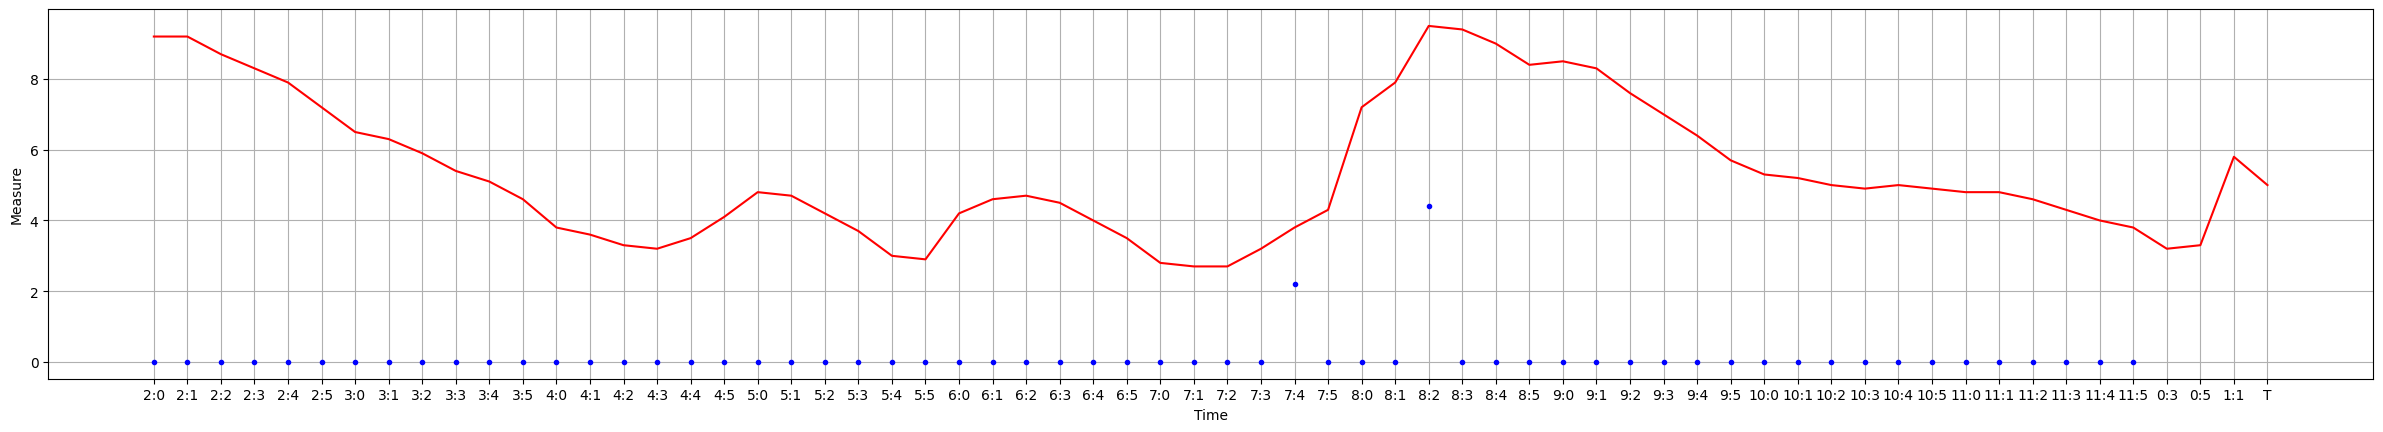

In [ ]:
gv = list(df_bg.drop(columns=['PtID', 'TargetDt']).values[1555])
ins = list(df_ins.drop(columns=['PtID', 'DeviceDtTmDaysFromEnroll']).values[1555])

fig, ax = plt.subplots()
fig.set_figwidth(30)
ax.plot(cols_bg, gv, '-', color='r', label='GV')
ax.plot(cols_ins, ins, '.', color='b', label='INS')
ax.set_xlabel("Time")
ax.set_ylabel("Measure")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

In [ ]:
from scipy.signal import savgol_filter

## Approach #4 (Regression + 15 targets)

### Data processing / feature engineering

In [ ]:
############################### targets
def isFeature2(data, time):
  for x, y in data.groupby('DeviceTm'):
    hours = x.seconds//3600
    minutes = (x.seconds - hours*3600) // 60
    if hours == time[0]:
      if abs(time[1] - minutes) <= 5:
        return y['GlucoseValue'].iloc[0]
  return -1

df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp.csv')
df_all = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/CGM_data_device.csv')

df_all['DeviceTm'] = pd.to_timedelta(df_all['DeviceTm'])

pt_dt = dict()
str_hm = dict()
hh = [0, 1, 2, 3]
mm = [0, 10, 20, 30, 40, 50]
for h in hh:
  for m in mm:
    hm = 't' + str(h) + ':' + str(m)
    str_hm[hm] = (h, m)

dummy = -1*np.ones([df.shape[0], 1])
for i in str_hm.keys():
  df.insert(df.shape[1], i, dummy)

for pt, i in df.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    pt_dt[(pt, dt)] = j.index[0]

for pt, i in df_all.groupby('PtID'):
  for dt, j in i.groupby('DeviceDtTmDaysFromEnroll'):
    if (pt, dt) in pt_dt.keys():
      idx = pt_dt[(pt, dt)]
      for hm in str_hm.keys():
        df[hm].iloc[idx] = isFeature2(j, str_hm[hm])

df.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp.csv', index=False)

In [ ]:
#cgm_exp_t_exp (37429, 87), no N/A

In [ ]:
df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp.csv')

str_hm = dict()
hh = [0, 1, 2, 3]
mm = [0, 10, 20, 30, 40, 50]
for h in hh:
  for m in mm:
    hm = 't' + str(h) + ':' + str(m)
    str_hm[hm] = (h, m)
arr = []
for pt, i in df.groupby('PtID'):
  for dt, j in i.groupby('TargetDt'):
    check = 1
    for hm in str_hm.keys():
      if j[hm].iloc[0] == -1:
        check = -1
    if check != -1:
      arr.append(j.values[0])

df_new = pd.DataFrame(arr, columns = df.columns)
df_new.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned.csv', index=False)

In [ ]:
#df_new.shape (36073, 87)

### Smoothing

In [ ]:
df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned.csv')
mm = [':0', ':1', ':2', ':3', ':4', ':5']
hh = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '0*', '1*', '2*', '3*']
cols = []
for h in hh:
  for m in  mm:
    cols.append(h + m)

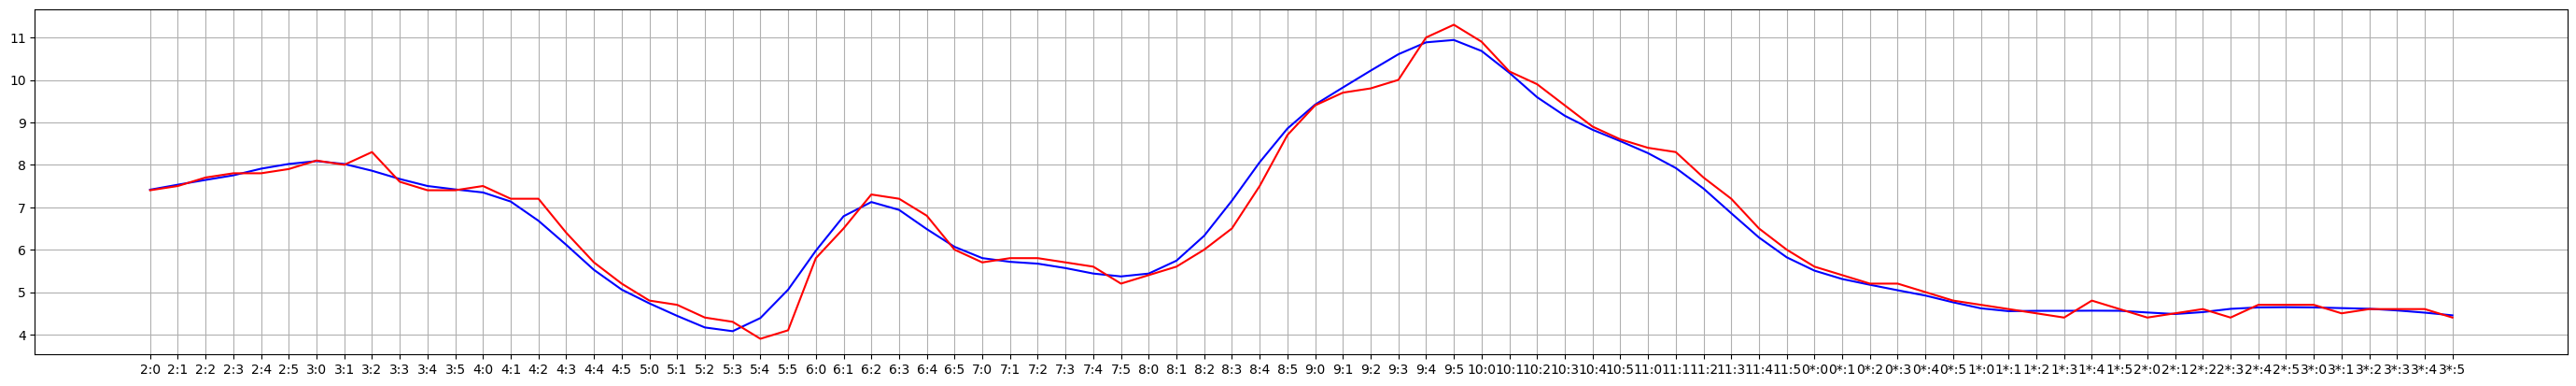

In [ ]:
c = df.drop(columns=['PtID', 'TargetDt', 'Target']).iloc[1546]
s = savgol_filter(x=c, window_length=5, polyorder=2)
s = savgol_filter(x=s, window_length=8, polyorder=2)

fig, ax = plt.subplots()
fig.set_figwidth(35)
ax.plot(cols, s, '-', color='b', label='smooth')
ax.plot(cols, c, '-', color='r', label='orig')
plt.grid()
plt.show()

In [ ]:
pt = df['PtID']
dt = df['TargetDt']
tg = df['Target']

df_sm = df.drop(columns=['PtID', 'TargetDt', 'Target'])
for i in range(df_sm.shape[0]):
  s = savgol_filter(x=df_sm.iloc[i], window_length=5, polyorder=2)
  df_sm.iloc[i] = savgol_filter(x=s, window_length=8, polyorder=2)
df_sm.insert(0, 'TargetDt', dt)
df_sm.insert(0, 'PtID', pt)
df_sm.insert(df_sm.shape[1], 'Target', tg)

df_sm.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned_Smooth.csv', index=False)

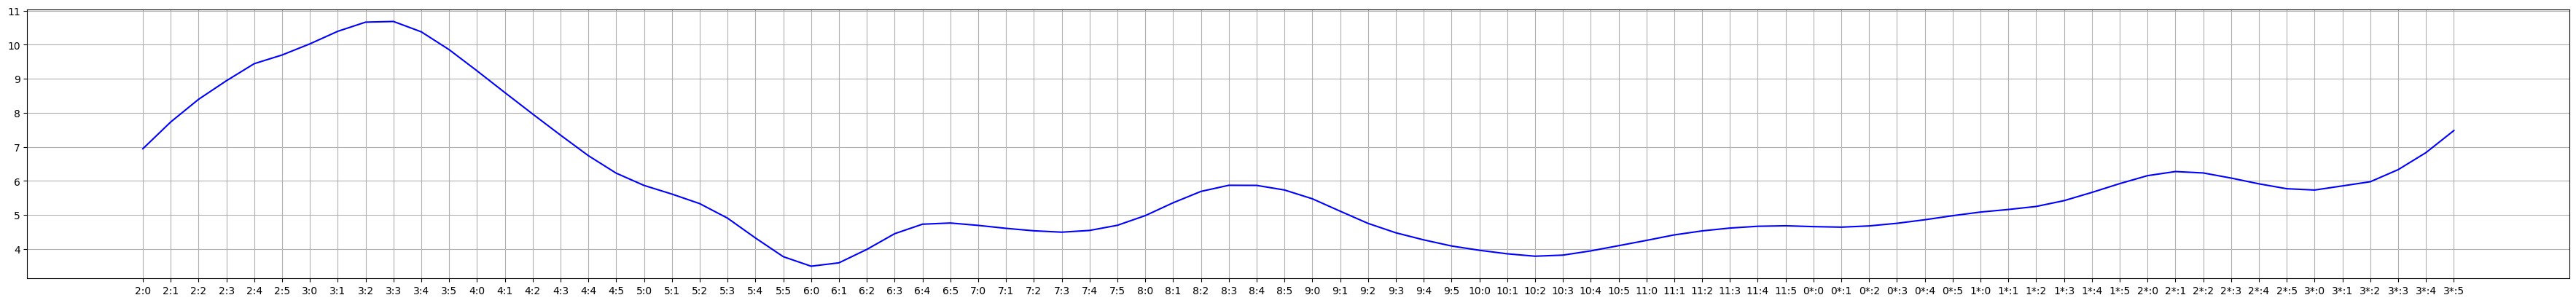

In [ ]:
df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned_Smooth.csv')
s = df.drop(columns=['PtID', 'TargetDt', 'Target']).iloc[155]

fig, ax = plt.subplots()
fig.set_figwidth(45)
ax.plot(cols, s, '-', color='b')
plt.grid()
plt.show()

In [ ]:
df.shape

(36073, 87)

### Pruning+Tuning

In [ ]:
############################### pruning
df_ins = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/Insulin_data.csv')
df_gv = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned_Smooth.csv')

ex_gv = set()
ex_ins = set()

df_ins['DeviceTm'] =  pd.to_timedelta(df_ins["DeviceTm"])

for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    tm = l['DeviceTm'].values
    first = pd.to_timedelta(list(l['DeviceTm'].values)[0]).seconds//3600
    if first < 6 :
      ex_gv.add((x, k))
      ex_ins.add((x, k))

for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    tm = l['DeviceTm'].values
    last = pd.to_timedelta(list(l['DeviceTm'].values).pop()).seconds//3600
    if last >= 23 :
      ex_gv.add((x, k + 1))
      ex_ins.add((x, k))

arr_gv = []
for x, y in df_gv.groupby('PtID'):
  for k, l in y.groupby('TargetDt'):
    s = (x, k)
    if s not in ex_gv:
      arr_gv.append(l.values[0])

df_GV_untuned = pd.DataFrame(arr_gv, columns=df_gv.columns)
df_GV_untuned = df_GV_untuned.dropna()
#df_GV_untuned.to_csv('gv_pruned_untuned.csv', index=False)

arr_ins = []
for x, y in df_ins.groupby('PtID'):
  for k, l in y.groupby('DeviceDtTmDaysFromEnroll'):
    for p, h in l.groupby('DeviceTm'):
      s = (x, k)
      if s not in ex_ins:
        arr_ins.append(h.values[0])


df_INS_untuned = pd.DataFrame(arr_ins, columns=df_ins.columns)
df_INS_untuned = df_INS_untuned.dropna()
#df_INS_untuned.to_csv('ins_pruned_untuned.csv', index=False)

############################### tuning
df_ins = df_INS_untuned
df_gv = df_GV_untuned

#clean INS
l = []
for pt, x in df_gv.groupby('PtID'):
  for dt, y in x.groupby('TargetDt'):
    l.append((pt, dt - 1))

arr = []
for pt, x in df_ins.groupby('PtID'):
  for dt, y in x.groupby('DeviceDtTmDaysFromEnroll'):
    for p, h in y.groupby('DeviceTm'):
      if (pt, dt) in l:
        arr.append(h.values[0])

df_ins_new = pd.DataFrame(arr, columns=df_ins.columns)
df_ins_new.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/expt_ins_of_Smooth_Tuned.csv', index=False)

#clean GV
l = []
for pt, x in df_ins_new.groupby('PtID'):
  for dt, y in x.groupby('DeviceDtTmDaysFromEnroll'):
    l.append((pt, dt + 1))

arr = []
for pt, x in df_gv.groupby('PtID'):
  for dt, y in x.groupby('TargetDt'):
    if (pt, dt) in l:
      arr.append(y.values[0])

df_gv_new = pd.DataFrame(arr, columns=df_gv.columns)
df_gv_new.to_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned_Smooth_Tuned.csv', index=False)

In [ ]:
pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/expt_ins_of_Smooth_Tuned.csv').shape

(56881, 4)

In [ ]:
#df_gv_new.shape (11179, 87), no N/A

(11179, 87)

### Model CNN

In [ ]:
df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned_Smooth.csv')
#X = df.values[:, 2:62]
#y = df.values[:, 62:86]
#X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=0)

#### to_image

In [ ]:
df_im = df.drop(columns=['PtID', 'TargetDt', 'Target'])
gv_max = np.max(df_im.values)
gv_min = np.min(df_im.values)
gv_mean = np.mean(df_im.values)
print([gv_max, gv_min, gv_mean])
print(df_im.shape)

[24.689017857142836, 0.4724999999999994, 9.090365367037764]
(36073, 84)


In [ ]:
ss = round(df_im / 25 * 84, 0).astype(int)

### Model SVR

In [ ]:
df = pd.read_csv('drive/MyDrive/Senior Project: Diabetes T1/Datasets/Dataset#2/Processed/cgm_exp_t_exp_Cleaned_Smooth_Tuned.csv')
X = df.values[:, 2:62]
y = df.values[:, 62:86]

In [ ]:
df.columns

Index(['PtID', 'TargetDt', 'f14:0', 'f14:10', 'f14:20', 'f14:30', 'f14:40',
       'f14:50', 'f15:0', 'f15:10', 'f15:20', 'f15:30', 'f15:40', 'f15:50',
       'f16:0', 'f16:10', 'f16:20', 'f16:30', 'f16:40', 'f16:50', 'f17:0',
       'f17:10', 'f17:20', 'f17:30', 'f17:40', 'f17:50', 'f18:0', 'f18:10',
       'f18:20', 'f18:30', 'f18:40', 'f18:50', 'f19:0', 'f19:10', 'f19:20',
       'f19:30', 'f19:40', 'f19:50', 'f20:0', 'f20:10', 'f20:20', 'f20:30',
       'f20:40', 'f20:50', 'f21:0', 'f21:10', 'f21:20', 'f21:30', 'f21:40',
       'f21:50', 'f22:0', 'f22:10', 'f22:20', 'f22:30', 'f22:40', 'f22:50',
       'f23:0', 'f23:10', 'f23:20', 'f23:30', 'f23:40', 'f23:50', 't0:0',
       't0:10', 't0:20', 't0:30', 't0:40', 't0:50', 't1:0', 't1:10', 't1:20',
       't1:30', 't1:40', 't1:50', 't2:0', 't2:10', 't2:20', 't2:30', 't2:40',
       't2:50', 't3:0', 't3:10', 't3:20', 't3:30', 't3:40', 't3:50', 'Target'],
      dtype='object')

In [ ]:
pipe = make_pipeline(StandardScaler(), SVR(C=2, epsilon=0.5))
kfold = skm.KFold(10, random_state=0, shuffle=True)

scoring = dict()
scoring['r2_score'] = make_scorer(r2_score)
scoring['mae_score'] = make_scorer(mean_absolute_error)
scoring['mape'] = make_scorer(mean_absolute_percentage_error)
toprints = ['Train r2', 'CV r2', 'Train MAE', 'CV MAE', 'Train MSE', 'CV MSE']

In [ ]:
regrs1 = []

r2_train1 = []
r2_val1 = []
mae_train1 = []
mae_val1 = []
mse_train1 = []
mse_val1 = []

for i in range(24):
  X_train, X_test, y_train, y_test = skm.train_test_split(X, y[:, i], test_size=0.2, random_state=0)
  grid = skm.GridSearchCV(pipe, {'memory': [None]}, scoring=scoring, cv=kfold, return_train_score=True, refit=False)
  grid.fit(X_train, y_train)
  regrs1.append(grid)

  r2_train1.append(grid.cv_results_['mean_train_r2_score'])
  r2_val1.append(grid.cv_results_['mean_test_r2_score'])

  mae_train1.append(grid.cv_results_['mean_train_mae_score'])
  mae_val1.append(grid.cv_results_['mean_test_mae_score'])

  mse_train1.append(grid.cv_results_['mean_train_mse'])
  mse_val1.append(grid.cv_results_['mean_test_mse'])

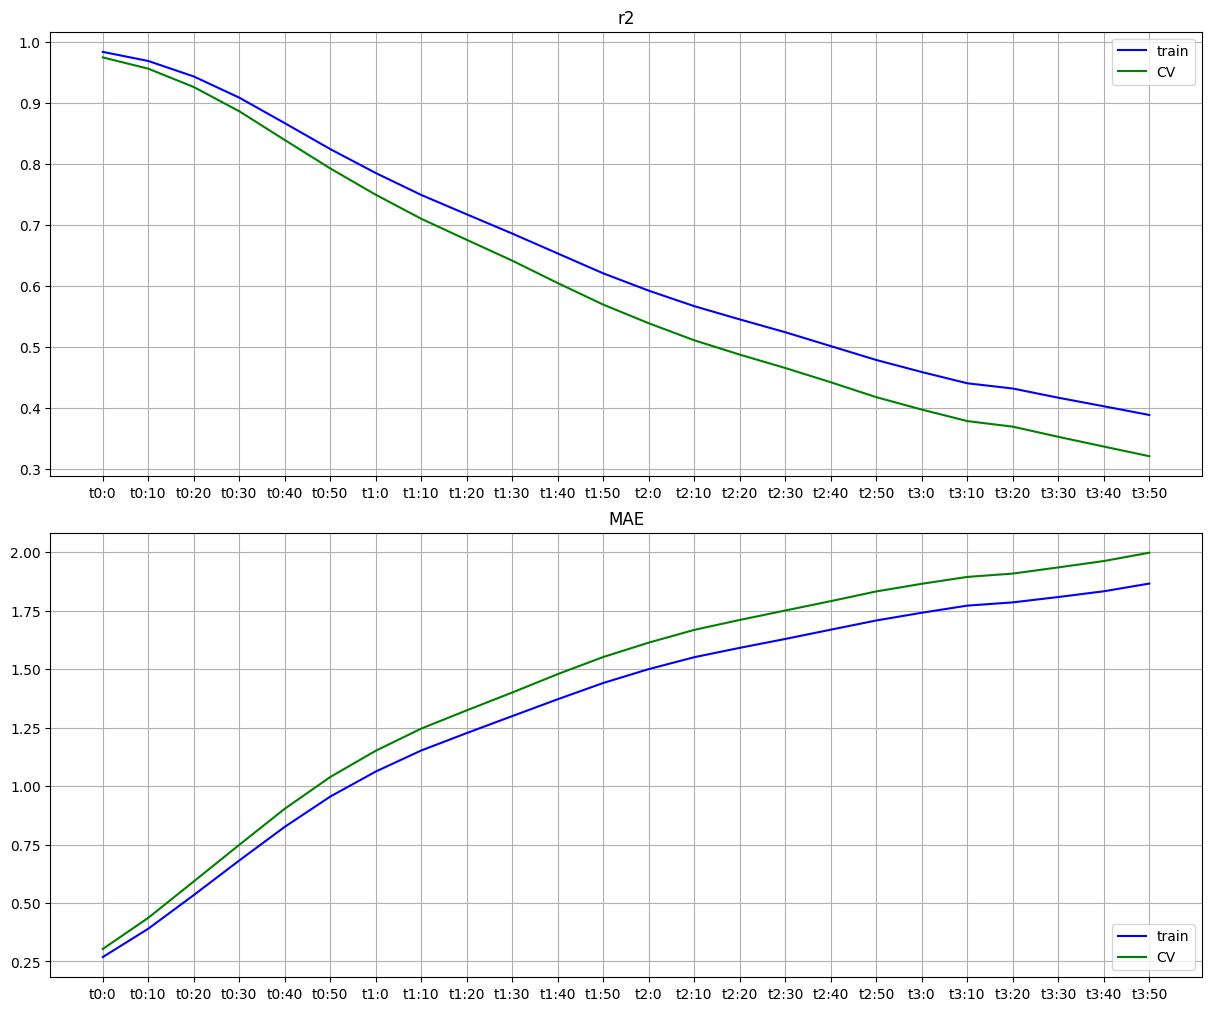

In [ ]:
fig, ax = plt.subplots(2, layout="constrained")
fig.set_figwidth(12)
fig.set_figheight(10)

ax[0].plot(df.columns[62:86], r2_train1, color='b', label='train')
ax[0].plot(df.columns[62:86], r2_val1, color='g', label='CV')
ax[0].set_title("r2")
ax[0].legend(loc='upper right')
ax[0].grid()

ax[1].plot(df.columns[62:86], mae_train1, color='b', label='train')
ax[1].plot(df.columns[62:86], mae_val1, color='g', label='CV')
ax[1].set_title("MAE")
ax[1].legend(loc='lower right')
ax[1].grid()
'''
ax[2].plot(df.columns[62:86], mse_train1, color='b', label='train')
ax[2].plot(df.columns[62:86], mse_val1, color='g', label='CV')
ax[2].set_title("MSE")
ax[2].legend(loc='lower right')
ax[2].grid()
'''
plt.show()


In [ ]:
X.shape

(11179, 60)

In [ ]:
regrs2 = []

r2_train2 = []
r2_val2 = []
mae_train2 = []
mae_val2 = []
mse_train2 = []
mse_val2 = []
X_i_2 = X[:, 24:60]

for i in range(24):
  X_train, X_test, y_train, y_test = skm.train_test_split(X_i_2, y[:, i], test_size=0.2, random_state=0)
  grid = skm.GridSearchCV(pipe, {'memory': [None]}, scoring=scoring, cv=kfold, return_train_score=True, refit=False)
  grid.fit(X_train, y_train)
  regrs2.append(grid)

  r2_train2.append(grid.cv_results_['mean_train_r2_score'])
  r2_val2.append(grid.cv_results_['mean_test_r2_score'])

  mae_train2.append(grid.cv_results_['mean_train_mae_score'])
  mae_val2.append(grid.cv_results_['mean_test_mae_score'])

  mse_train2.append(grid.cv_results_['mean_train_mape'])
  mse_val2.append(grid.cv_results_['mean_test_mape'])

In [ ]:
regrs2 = []

r2_train2 = []
r2_val2 = []
mae_train2 = []
mae_val2 = []
mse_train2 = []
mse_val2 = []

for i in range(24):
  if i == 0:
    X_i = X
  else:
    X_i = np.c_[X_i, y[:, i - 1]]
  X_train, X_test, y_train, y_test = skm.train_test_split(X_i, y[:, i], test_size=0.2, random_state=0)
  grid = skm.GridSearchCV(pipe, {'memory': [None]}, scoring=scoring, cv=kfold, return_train_score=True, refit=False)
  grid.fit(X_train, y_train)
  regrs2.append(grid)
  r2_train2.append(grid.cv_results_['mean_train_r2_score'])
  r2_val2.append(grid.cv_results_['mean_test_r2_score'])

  mae_train2.append(grid.cv_results_['mean_train_mae_score'])
  mae_val2.append(grid.cv_results_['mean_test_mae_score'])

  mse_train2.append(grid.cv_results_['mean_train_mape'])
  mse_val2.append(grid.cv_results_['mean_test_mape'])